## In Class Excersise 3: Fitting practicum

The goal of this exercise is to familiarize you with basic ideas and execution mechanics of
nonlinear curve fitting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load the data into your software
creating variables from the data file for the dimensions
x, y, and z, and the volume V

In [3]:
# downloading and getting data into a table 
cube = pd.read_table('/home/kal/jLab/cubeData.csv', delimiter=',', header=None)
cube.columns = 'YY.Mmm.B0X.nn num x x_uncert y y_uncert z z_uncert volume v_uncert'.split()
cube.head()

,YY.Mmm.B0X.nn,num,x,x_uncert,y,y_uncert,z,z_uncert,volume,v_uncert
0,14.Sep.B01.01,1,9.0,0.2,10.4,0.2,36.8,0.3,3400.0,200.00
1,14.Sep.B01.02,2,9.1,0.6,10.5,1.0,36.8,0.8,3500.0,400.00
2,14.Sep.B01.03,3,8.9,0.1,10.1,0.3,36.5,0.3,3281.0,0.44
3,14.Sep.B01.04,4,9.0,0.5,10.4,0.5,36.9,0.5,3400.0,0.90
4,14.Sep.B01.05,5,8.9,0.1,10.4,0.1,37.0,0.1,3400.0,51.00


__You should examine the data visually__ and statistically to convince yourself the data is sound enough to
continue analyzing.

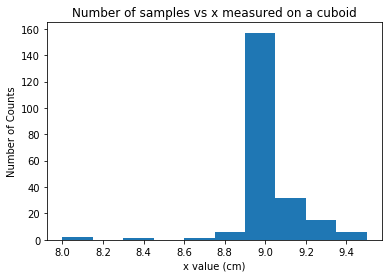

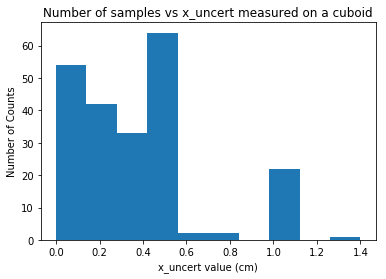

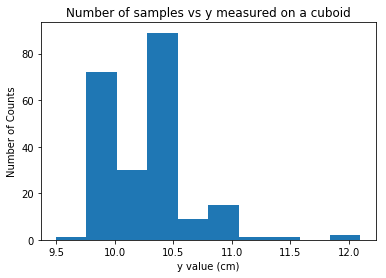

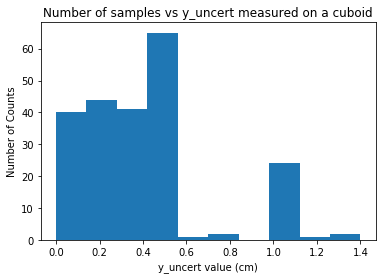

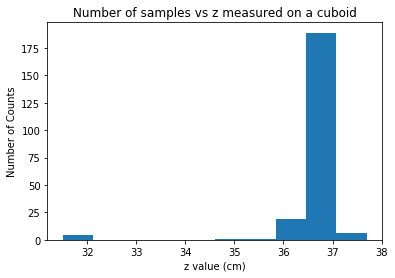

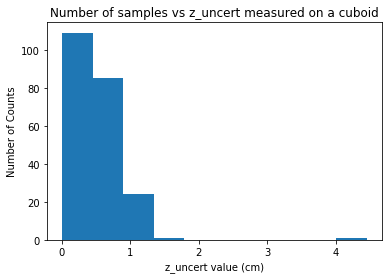

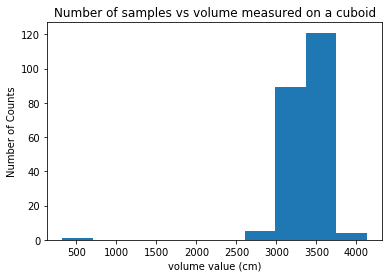

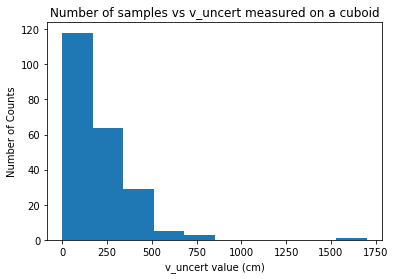

In [4]:
for key in 'x x_uncert y y_uncert z z_uncert volume v_uncert'.split():
        plt.hist(cube[key])
        plt.title('Number of samples vs {} measured on a cuboid'.format(key))
        plt.xlabel('{} value (cm)'.format(key))
        plt.ylabel('Number of Counts')
        plt.show()

I'm going to recompute volume myself - there appear to be some errors in volume calculation. No outliers are too crazy, but there is definetly variation. 

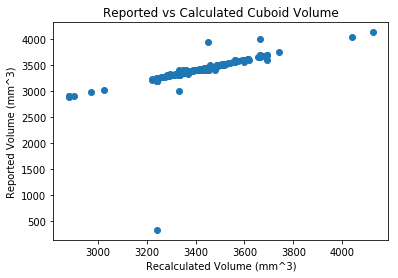

In [5]:
cube['calculated_v'] = cube['x'] * cube['y'] * cube['z']
plt.scatter(cube['calculated_v'], cube['volume'])
plt.title('Reported vs Calculated Cuboid Volume')
plt.ylabel('Reported Volume (mm^3)')
plt.xlabel('Recalculated Volume (mm^3)')
plt.show()

### Bin the data into a histogram.
Choose a number of bins which is large enough that several counts occupy each bin, but not so large as to loose resolution. Note: it is neither sufficient nor necessary to plot the histogram at this time. Rather, you need the arrays of numbers which indicate the counts in each bin and the bin locations.

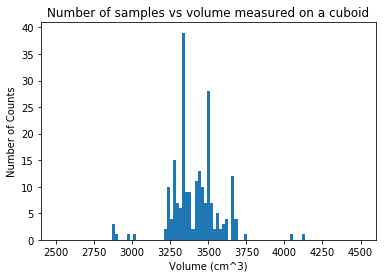

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  3.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.
 10.  4. 15.  7.  6. 39.  9.  9.  2. 11. 13. 10.  7. 28.  7.  2.  5.  2.
  3.  4.  0. 12.  4.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [13]:
bins = np.linspace(2500, 4500, 100)
binned = plt.hist(cube['calculated_v'], bins)
plt.title('Number of samples vs volume measured on a cuboid')
plt.xlabel('Volume (cm^3)')
plt.ylabel('Number of Counts')
plt.show()

print(binned[0])

### Perform an initial fit of the histogram to a Gaussian function.
That is, find the mean value, width, and amplitude of a Gaussian function which minimize the value of χ2 between the Gaussian and the histogrammed data.
* The data points and uncertainties which are the inputs to the fit are not the raw data and uncertainties reported in the downloaded data file, but rather those of the histogram bins.
* Under the assumption that the number of counts in each bin is uncorrelated with the others, then the uncertainty for each bin is given by treating it as a Poisson random variable.
* You should be critically skeptical of your fitting algorithm. Check whether the best-fit parameters returned actually produce a Gaussian which resembles the histogram. Check whether the algorithm has exited without converging to a solution. Check whether changing your initial guess for the fit parameters or changing the numerical control constants of the algorithm (e.g., the minimum change in χ2 before the algorithm exits) significantly changes the fit results.

In [31]:
# get the values
values = [b for b in binned[0] if b !=0]
# get the uncertainties
uncerts = np.sqrt(values)
# get the bin centers
bin_centers = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
x_vals = [b for a, b in zip(binned[0], bin_centers) if a !=0]

In [49]:
from scipy.optimize import curve_fit
# set up a gaussian
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [20, 3500, 200]
popt, pcov = curve_fit(gauss, x_vals, values, p0=p0, sigma=uncerts)

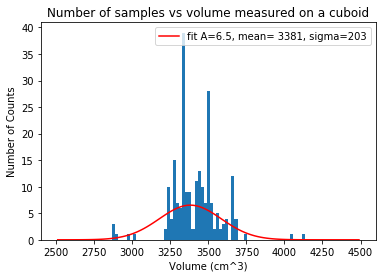

In [63]:
# plot the fit
binned = plt.hist(cube['calculated_v'], bins)
plt.title('Number of samples vs volume measured on a cuboid')
plt.xlabel('Volume (cm^3)')
plt.ylabel('Number of Counts')
plt.plot(bin_centers, gauss(bin_centers, *popt), 'r-', label='fit A=%2.1f, mean=%5.0f, sigma=%1.0f' % tuple(popt))
plt.legend()
plt.show()

### Perform a final fit and evaluate it statistically

* Record the minimum value of χ2. Also calculate the so-called “reduced χ2”: χ2ν = χ2/ν, where ν = (N − nc) is the degrees of freedom for the fit, N is the number of data points being fit, and nc is the number of parameters being varied in the fit.
* Record the best-fit values for the fit parameters.
* Record the one-standard-deviation uncertainties in the best-fit parameters. This should be equal to the amount by which you must change a parameter away from the minimum to increase χ 2 by 1.
* Calculate the probability that a model with these parameters would give rise to measurements with a χ2 value equal to or greater than the χ2 of your data. That is to say, how believable is the hypothesis that this model describes your data?
* If necessary, use propagation-of-error techniques to translate the uncertainties in your fit parameters into uncertainties on quantities about which you care. (For example, if one were to fit data from a radioactive decay experiment to a decaying exponential Ae−kt so as to extract the rate constant k, but were actually more interested in the mean lifetime defined as τ ≡ 1/k, then one would calculate στ = σk/k2 .)


In [65]:
# find x squares
def chi_squared(x, fit, sig):
     return np.sum(np.square(x-fit)/np.square(sig))
chi_squared(values, gauss(x_vals, *popt), uncerts)

96.62000315512404

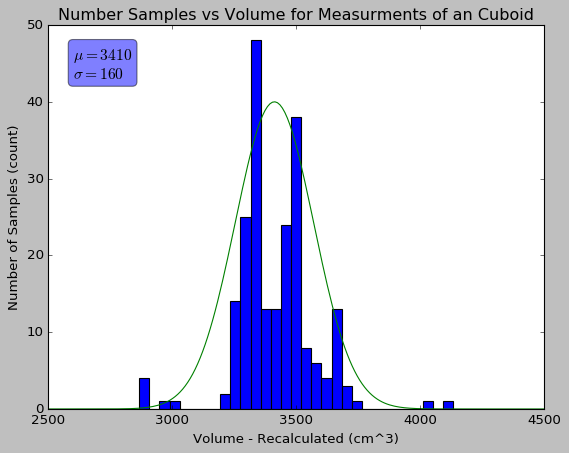

In [105]:
# or, a prettier version
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')


x_vals = np.linspace(2500, 4500, 200)

fig, ax = plt.subplots()

bins= np.linspace(2500, 4500, 50)

ax.hist(cube['calculated_v'], bins=bins)
ax.set_title('Number Samples vs Volume for Measurments of an Cuboid')
ax.set_ylabel('Number of Samples (count)')
ax.set_xlabel('Volume - Recalculated (cm^3)')

ax.plot(x_vals, 40*gaussian(x_vals, mu, sigma))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


plt.show()


Now, create a paper quality graphic

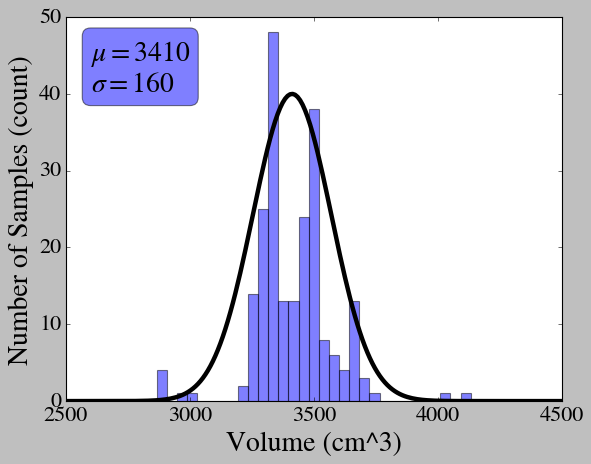

In [106]:
# or, a prettier version
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

#set up plot
x_vals = np.linspace(2500, 4500, 200)
fig, ax = plt.subplots()

#histogram
bins= np.linspace(2500, 4500, 50)
ax.hist(cube['calculated_v'], bins=bins, alpha=0.5)

#make text
#ax.set_title('Volume Distribution for \nMeasurments of a Cuboid')
#ax.title.set_fontsize(35)
ax.set_ylabel('Number of Samples (count)')
ax.yaxis.label.set_fontsize(25)
ax.set_xlabel('Volume (cm^3)')
ax.xaxis.label.set_fontsize(25)
y = ax.get_yticklabels()
for i in y:
    i.set_fontsize(20)
    
x = ax.get_xticklabels()
for i in x:
    i.set_fontsize(20)

#plot gaussian
ax.plot(x_vals, 40*gaussian(x_vals, mu, sigma), c='black', linewidth='4')

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', fc="b", alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=25,
        verticalalignment='top', bbox=props)


plt.show()